In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
PATH = "~/1.Data/4. Leakage"
YEARS = ["2017", "2018", "2019", "2020", "2021"]
FILE_NAMES = [x+"_data_for_leakage_algorithm.csv" for x in YEARS]
LEAKED_FILE_NAME = "leaked.csv"

# C:/Users/sassijoh/PycharmProjects/leakage_dev/data/leakage_detection/leaked.csv

In [3]:
quarter_column_name = "ST Quarter"
billing_qty_column_name = "Billing Net Qty"
billing_val_column_name = "Billing Net Value $"
resale_qty_column_name="Resale Qty"	
resale_val_column_name="Resale Value in US$"
pop_price_column_name="Resale Buyer Price in US$" 	
pos_price_column_name="Resale Price in US$"	
product_columns_name="Commercial Product Code"	
direct_customer_column_name="Direct Customer Group - Others"	
final_customer_column_name="ST Disti Final Customer Group Others"
leaked_column_name = "leaked?"
margin_column_name = "Disty margin"
var_margin_column_name = "Disty margin var"

In [4]:
columns_group = [quarter_column_name,product_columns_name]
columns_count = [direct_customer_column_name, final_customer_column_name] 
columns_sum = [billing_qty_column_name, billing_val_column_name, resale_qty_column_name, resale_val_column_name]
columns_mean = [pos_price_column_name, pop_price_column_name, margin_column_name]

In [5]:
df_leaked = pd.read_csv(os.path.join(PATH, LEAKED_FILE_NAME))
df_leaked.loc[:,"Quarter label"] = df_leaked["Quarter"].apply(lambda quarter_number : "Q20210"+str(quarter_number))
list_pn = set(df_leaked["PN"])

In [6]:
df = pd.DataFrame()
for i, file_name in enumerate(FILE_NAMES):
    df_tmp = pd.read_csv(os.path.join(PATH, file_name))
    df = pd.concat([df, df_tmp])
df.loc[:, leaked_column_name] = df[product_columns_name].apply(lambda x: x in list_pn)
df.loc[:,margin_column_name] = df.apply(lambda row:row[pos_price_column_name]/row[pop_price_column_name]-1 if row[pop_price_column_name]!=0 else None,axis=1)

In [7]:
df_group = df[columns_group+columns_sum].groupby(columns_group).sum()
df_group.loc[:,columns_mean] = df[columns_group+columns_mean].groupby(columns_group).mean()
df_group.loc[:,columns_count] = df[columns_group+columns_count].groupby(columns_group).nunique()
df_group.loc[:,var_margin_column_name] = df[columns_group+[margin_column_name]].dropna(how='any').groupby(columns_group).var()[margin_column_name]
df_group.loc[:, leaked_column_name] = df_group.apply(lambda row: row.name[1] in list_pn,axis=1)

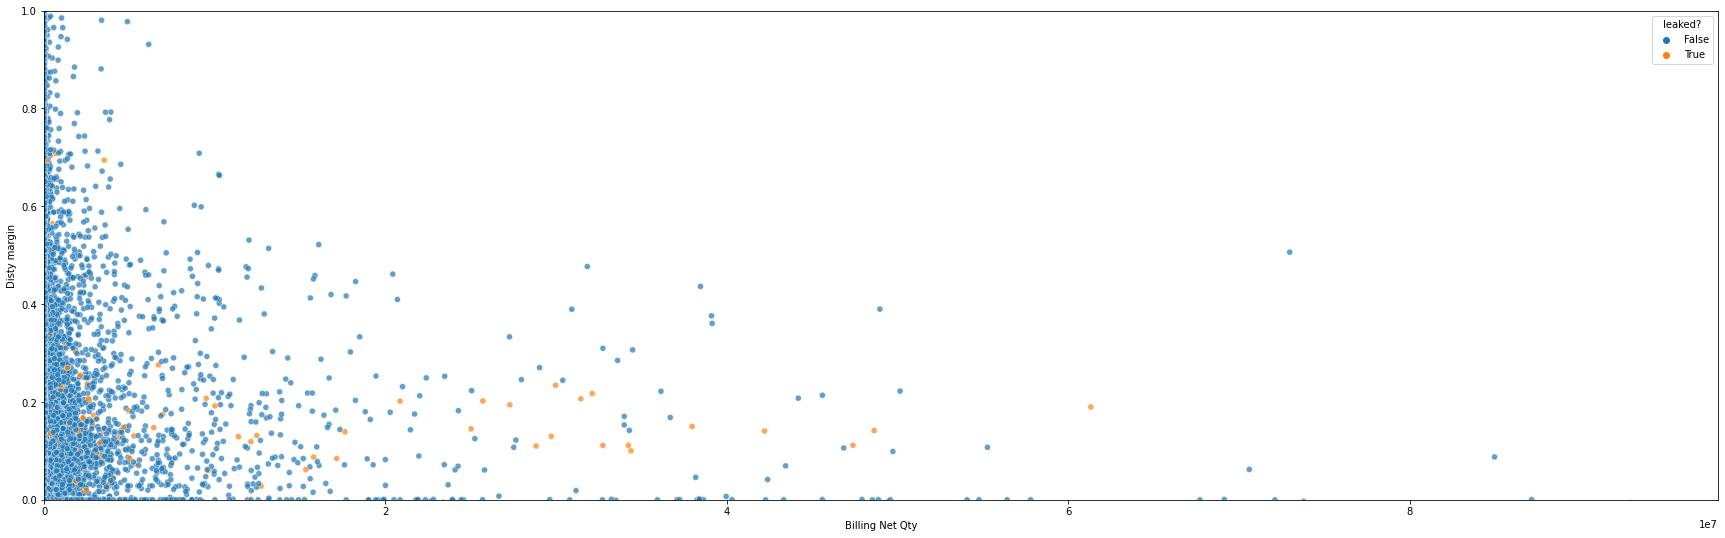

In [8]:
a4_dims = (30, 9)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.scatterplot(ax=ax, data=df_group, x=billing_qty_column_name, y=margin_column_name, hue=leaked_column_name, alpha=0.7)
g.set(ylim=(0,1), xlim=(0,None));

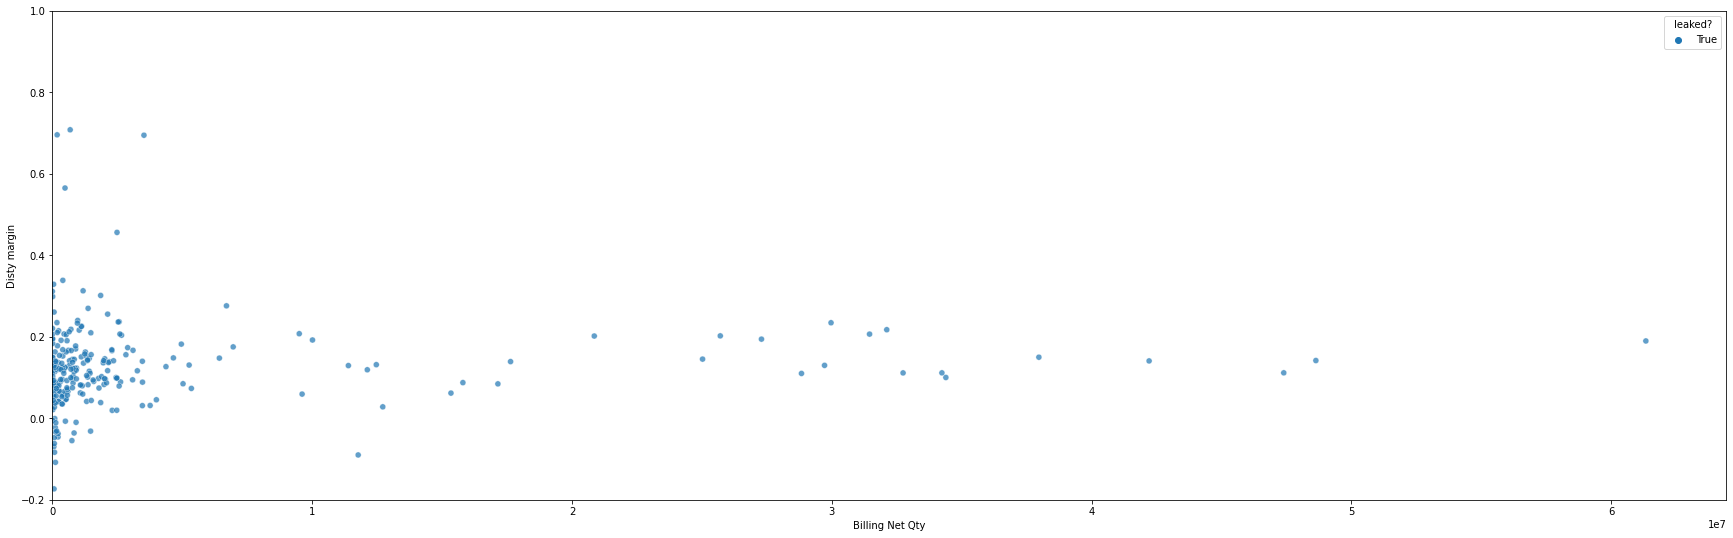

In [9]:
# df_plot = df_group[df_group[margin_column_name]<0]
df_plot = df_group[df_group[leaked_column_name]]
a4_dims = (30, 9)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.scatterplot(ax=ax, data=df_plot, x=billing_qty_column_name, y=margin_column_name, hue=leaked_column_name, alpha=0.7)
g.set(ylim=(-0.2,1), xlim=(0,None));

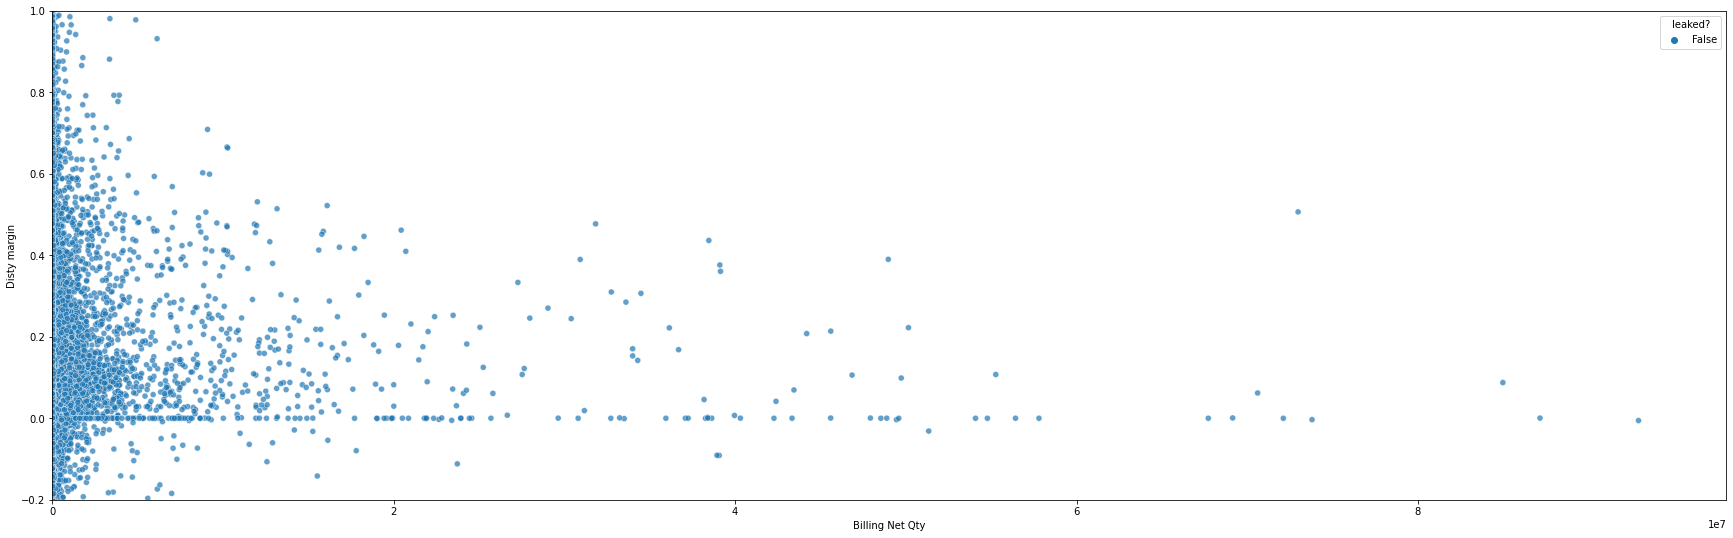

In [10]:
# df_plot = df_group[df_group[margin_column_name]<0]
df_plot = df_group[~df_group[leaked_column_name]]
a4_dims = (30, 9)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.scatterplot(ax=ax, data=df_plot, x=billing_qty_column_name, y=margin_column_name, hue=leaked_column_name, alpha=0.7)
g.set(ylim=(-0.2,1), xlim=(0,None));

In [11]:
df_sample = df_group.groupby(leaked_column_name).apply(lambda s: s.sample(100))

[(-0.2, 1.0), (-0.2, 1.0)]

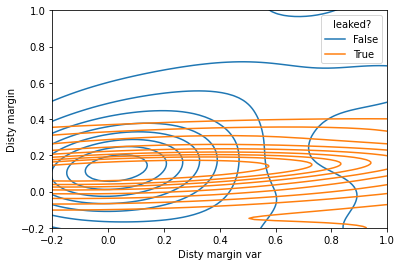

In [12]:
g = sns.kdeplot(data=df_sample, x=var_margin_column_name, y=margin_column_name, hue=leaked_column_name)
g.set(ylim=(-0.2, 1), xlim=(-0.2, 1))

# Test Aymeric results 

In [13]:
df_results = pd.read_csv(os.path.join(PATH, "af_algo_results_v3.csv"))
# df_results = pd.read_csv(os.path.join(PATH, "af_algo_results.csv"))
df_results.loc[:,"Quarter"] = df_results.apply(lambda row:"Q"+str(row["Year"])+"0"+str(row["Quarter"]),axis=1)

In [14]:
df_results.loc[:, leaked_column_name] = df_results[product_columns_name].apply(lambda x: x in list_pn)

In [15]:
df_results.columns

Index(['Year', 'Quarter', 'Channel Sales Area', 'Channel Customer Group',
       'ST Disti Customer Group  - Others', 'ST Disti Ship-To-Name',
       'ST Disti Final Customer Group  - Others', 'Product Division',
       'Commercial Product Code', 'ST Disti Final Ship-To-Name', 'VAR Name',
       'Average_POP', 'Average_POS', 'lowest_pop1', '50%_POP',
       'Sum_Resale_Qty', 'Shipment', 'Disti_Margin', 'Disti_avg_margin',
       'Running_CP', 'CTM_Bill_avgmonth', 'Nb_price', 'DiffCTM',
       'Repart_price', 'Repart80_price', 'G_Shipment', 'G_Disti_Margin',
       'G_P%_Qty', 'G_CTM_Bill_avgmonth', 'G_Running_CP', 'G_Nb_price',
       'G_DiffCTM', 'G_Repart_price', 'G_Repart80_price', 'G_Cumul_ShipPrice',
       'G_New_CTM', 'G_VAR_Margin', 'Average_High', 'Average_Mid',
       'Weight_avg', 'alert_level', 'VAR_Margin', 'nb_alert', 'nb_alarming',
       'P%_Alarming', 'leaked?'],
      dtype='object')

In [16]:
def construct_df_ratio(df_tmp=df_results):
    df_ratio = pd.DataFrame(df_tmp.groupby([product_columns_name]).count()["alert_level"])
    df_ratio.loc[:,"nb alarming"] = df_tmp[df_tmp["alert_level"]=="Alarming"].groupby([product_columns_name]).count()["alert_level"]
    df_ratio = df_ratio.rename(columns={"alert_level":"nb cases"})
    df_ratio.loc[:, "ratio alarming"] = df_ratio.apply(lambda row:row["nb alarming"]/row["nb cases"] if row["nb alarming"] is not None else 0,axis=1).fillna(0)
    df_ratio.loc[:, leaked_column_name] = df_ratio.index.map(lambda x: x in list_pn)
    return df_ratio
df_ratio = construct_df_ratio()

In [52]:
g = sns.displot(data=df_ratio, x="ratio alarming", hue=leaked_column_name, kde=True)

ValueError: `kind` must be one of ['hist', 'kde', 'ecdf'], but True was passed.`

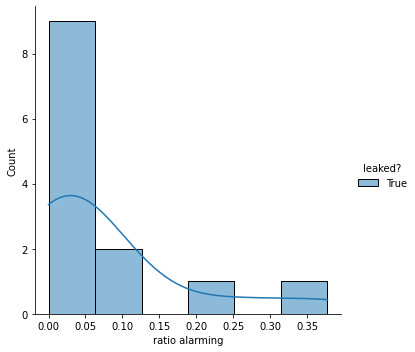

In [18]:
g = sns.displot(data=df_ratio[df_ratio[leaked_column_name]], x="ratio alarming", hue=leaked_column_name, kde=True)

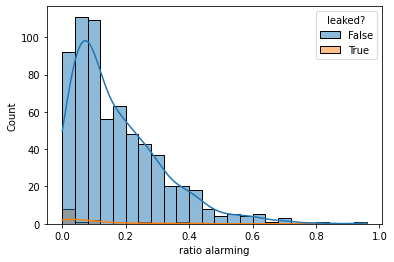

In [19]:
g = sns.histplot(data=df_ratio[df_ratio["nb cases"]>20], x="ratio alarming", hue=leaked_column_name, kde=True)

In [20]:
df_ratio.groupby(leaked_column_name).count()


,nb cases,nb alarming,ratio alarming
leaked?,,,
False,2120,2099,2120
True,13,12,13


In [21]:
df_ratio_group = df_ratio.groupby(leaked_column_name).sum()
df_ratio_group["ratio alarming"] = df_ratio_group["nb alarming"]/df_ratio_group["nb cases"]

In [22]:
df_ratio_group

,nb cases,nb alarming,ratio alarming
leaked?,,,
False,66691,10968.0,0.164460
True,7099,170.0,0.023947


# Filtering on the number of cases

In [23]:
def compute_ratios_by_num_cases_threshold(limit):
    df_ratio_top = df_ratio[df_ratio["nb cases"]>limit]
    return (df_ratio_top[df_ratio_top[leaked_column_name]]["ratio alarming"].mean(),df_ratio_top[df_ratio_top[leaked_column_name]==False]["ratio alarming"].mean())
    
ratios_list_leaked = [compute_ratios_by_num_cases_threshold(x)[0] for x in range(1,1000)]
ratios_list_not_leaked = [compute_ratios_by_num_cases_threshold(x)[1] for x in range(1,1000)]


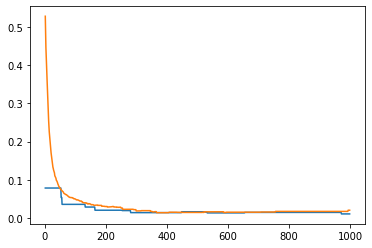

In [24]:
plt.plot(range(1,1000), ratios_list_leaked)
plt.plot(range(1,1000), ratios_list_not_leaked)

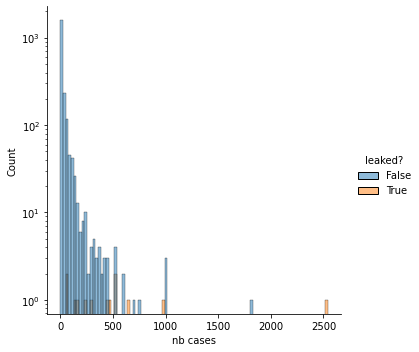

In [25]:
sns.displot(data=df_ratio, x="nb cases", hue="leaked?", log_scale=(False, True), bins=100)

In [26]:
df_matrix = df_results[[column for column in df_results.columns if "G_" in column]+[leaked_column_name]]
df_matrix_sample = df_matrix.groupby(leaked_column_name).apply(lambda s: s.sample(2000))

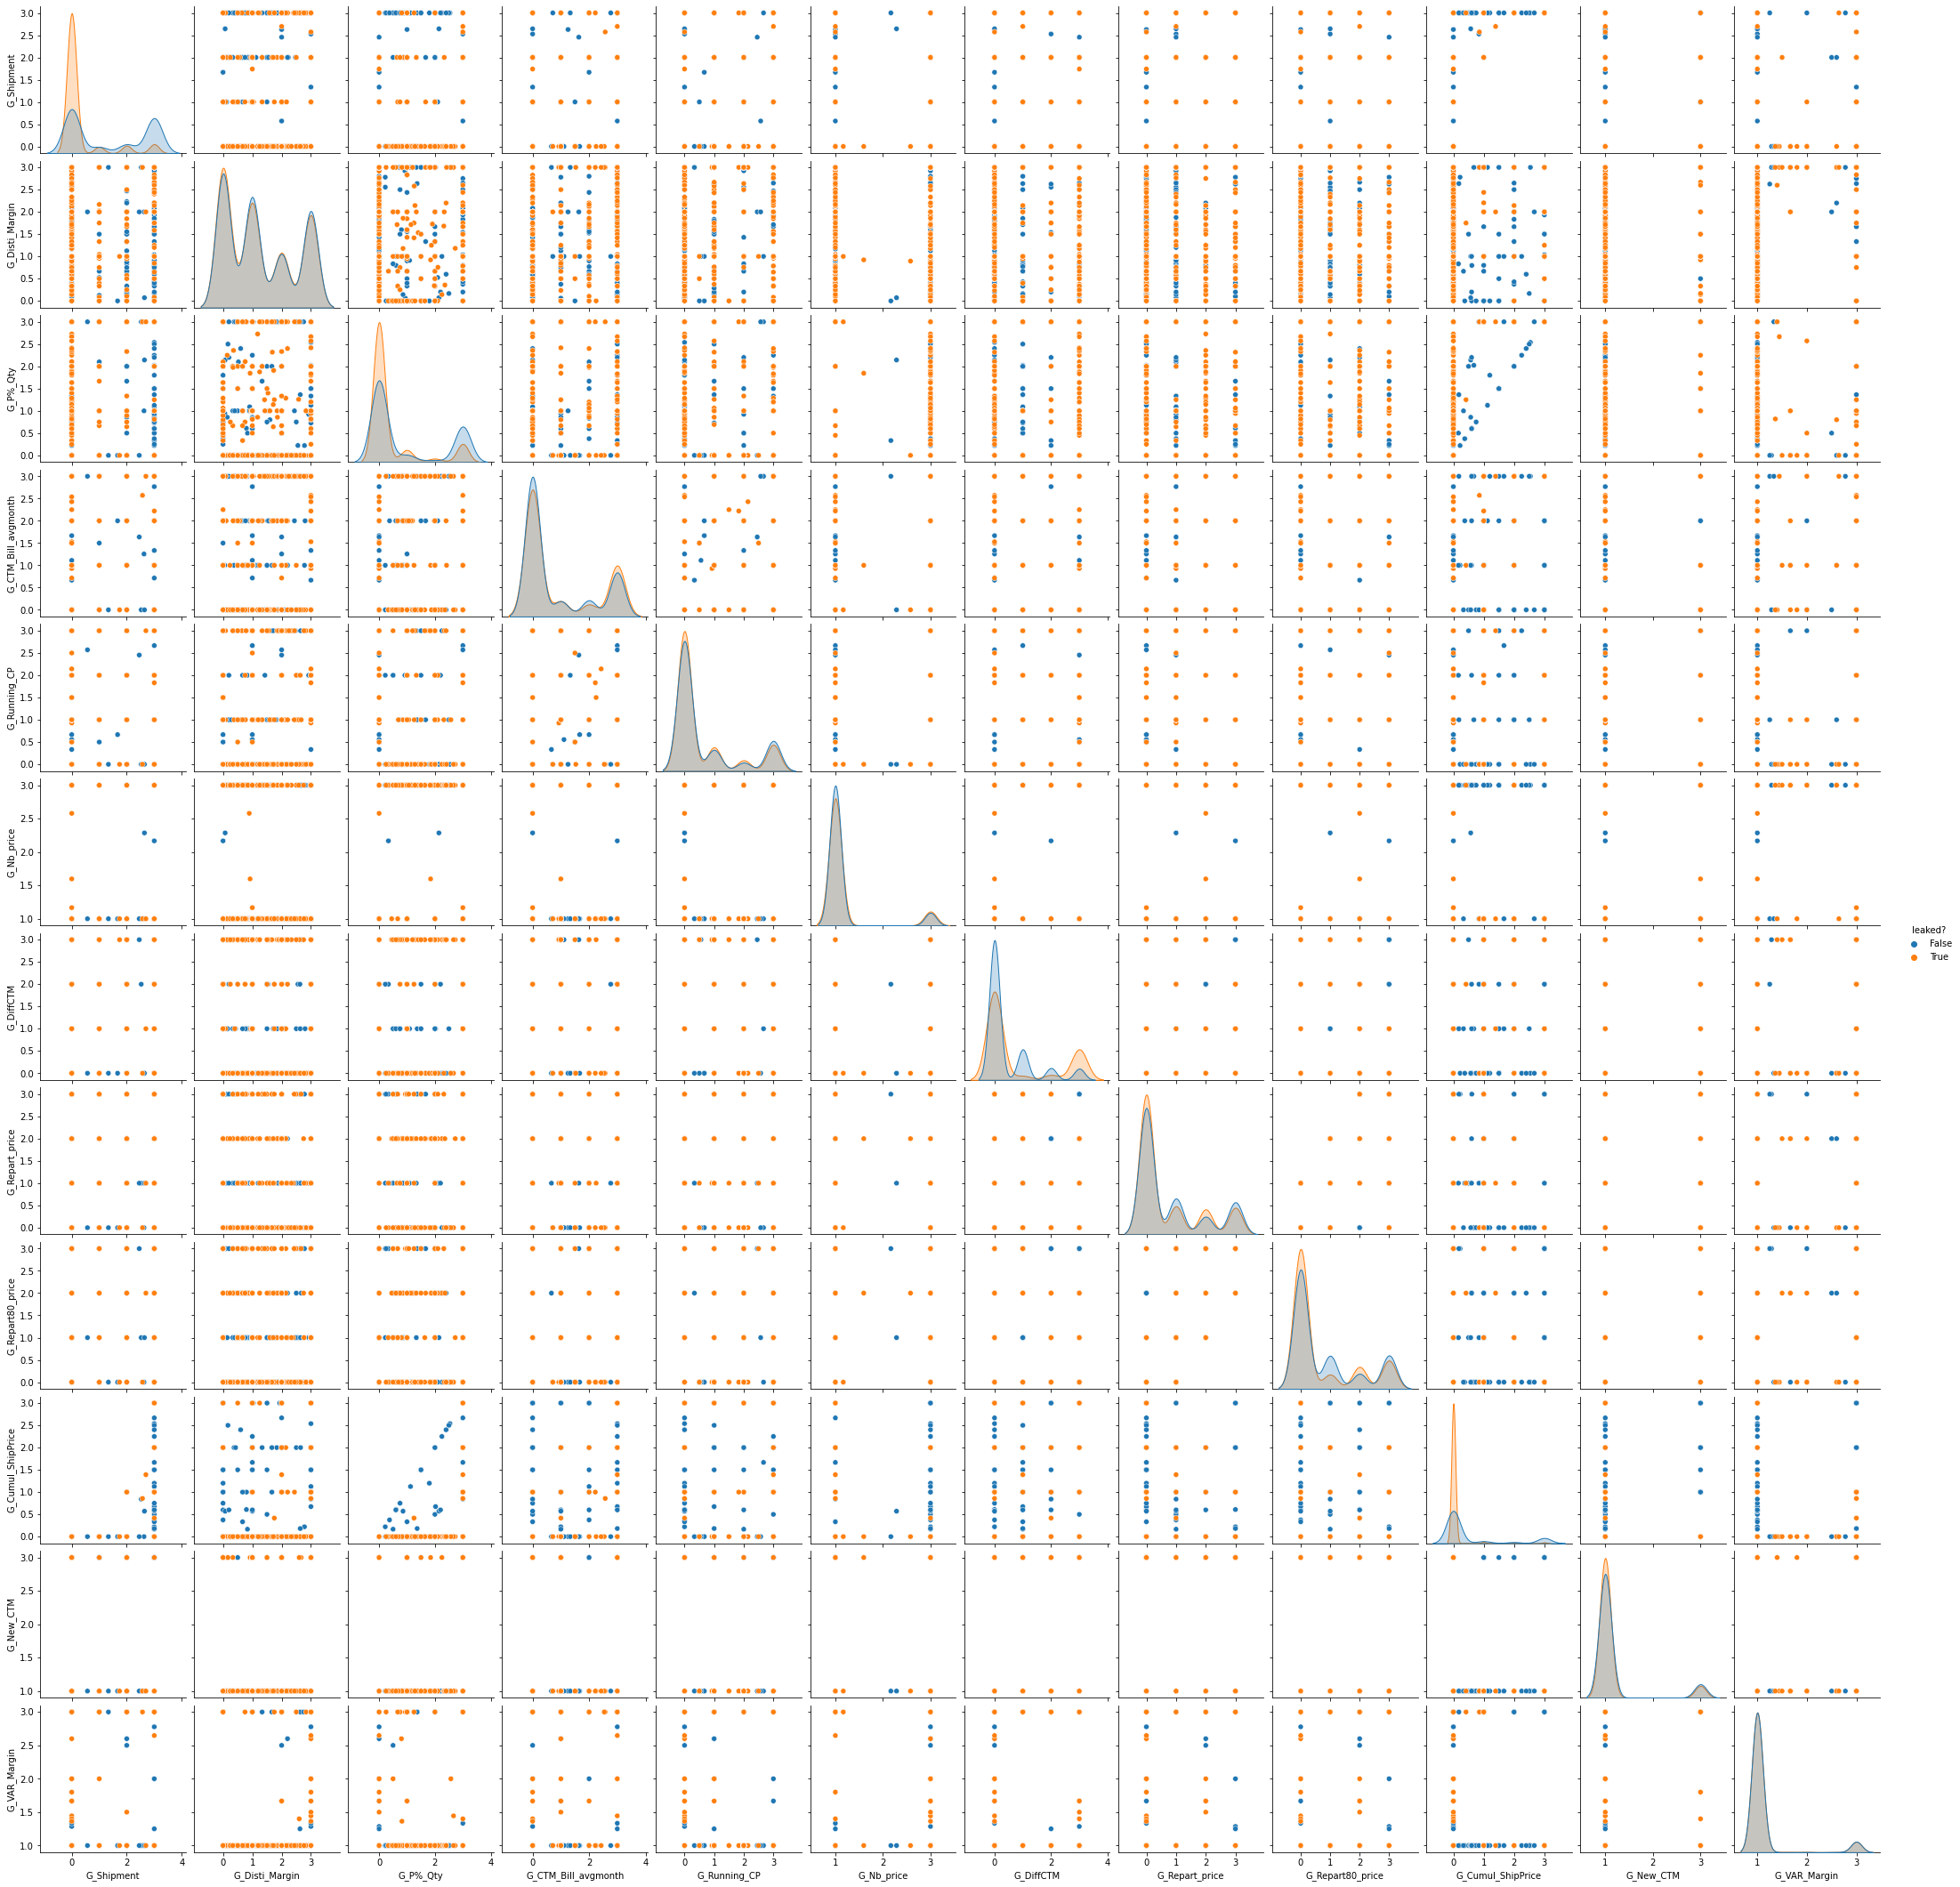

In [27]:
sns.pairplot(data=df_matrix_sample, hue=leaked_column_name)

# Only on 2021

In [28]:
df_leaked_end_2021 = df_leaked[df_leaked["Quarter"]>=2]
df_results_2021 = df_results[df_results["Year"]==2021]

In [29]:
df_matrix_2021 = df_results_2021[[column for column in df_results.columns if "G_" in column]+[leaked_column_name]]
df_matrix_2021_sample = df_matrix_2021.groupby(leaked_column_name).apply(lambda s: s.sample(1000))

In [30]:
df_matrix_2021_sample

G_Shipment  G_Disti_Margin  G_P%_Qty  G_CTM_Bill_avgmonth  \
leaked?                                                                    
False   69306         0.0        2.000000  0.000000                  0.0   
        63791         3.0        0.764706  1.647059                  1.0   
        67225         0.0        0.000000  3.000000                  0.0   
        67495         1.0        0.000000  0.000000                  2.0   
        66779         3.0        0.000000  0.000000                  0.0   
...                   ...             ...       ...                  ...   
True    71478         0.0        0.000000  0.000000                  3.0   
        63132         0.0        1.300000  0.900000                  0.0   
        60133         0.0        0.000000  3.000000                  0.0   
        71035         0.0        0.000000  0.000000                  0.0   
        60206         0.0        0.000000  2.000000                  0.0   

               G_Running_CP  G_Nb_price  G_DiffCTM  G_Repart_price  \
leaked?                                                              
False   69306           0.0         1.0          1               1   
        63791           1.0         3.0          0               3   
        67225           0.0         1.0          0               2   
        67495           0.0         1.0          3               3   
        66779           0.0         1.0          1               0   
...                     ...         ...        ...             ...   
True    71478           1.0         1.0          0               1   
        63132           3.0         3.0          3               1   
        60133           0.0         1.0          3               2   
        71035           0.0         1.0          0               2   
        60206           1.0         1.0          3               2   

               G_Repart80_price  G_Cumul_ShipPrice  G_New_CTM  G_VAR_Margin  \
leaked?                                                                       
False   69306                 1                0.0          1           1.0   
        63791                 3                0.0          1           1.0   
        67225                 2                0.0          1           1.0   
        67495                 3                0.0          1           1.0   
        66779                 0                0.0          1           1.0   
...                         ...                ...        ...           ...   
True    71478                 2                0.0          1           1.0   
        63132                 0                0.0          1           1.0   
        60133                 2                0.0          1           3.0   
        71035                 2                0.0          1           1.0   
        60206                 1                0.0          1           1.0   

               leaked?  
leaked?                 
False   69306    False  
        63791    False  
        67225    False  
        67495    False  
        66779    False  
...                ...  
True    71478     True  
        63132     True  
        60133     True  
        71035     True  
        60206     True  

[2000 rows x 13 columns]

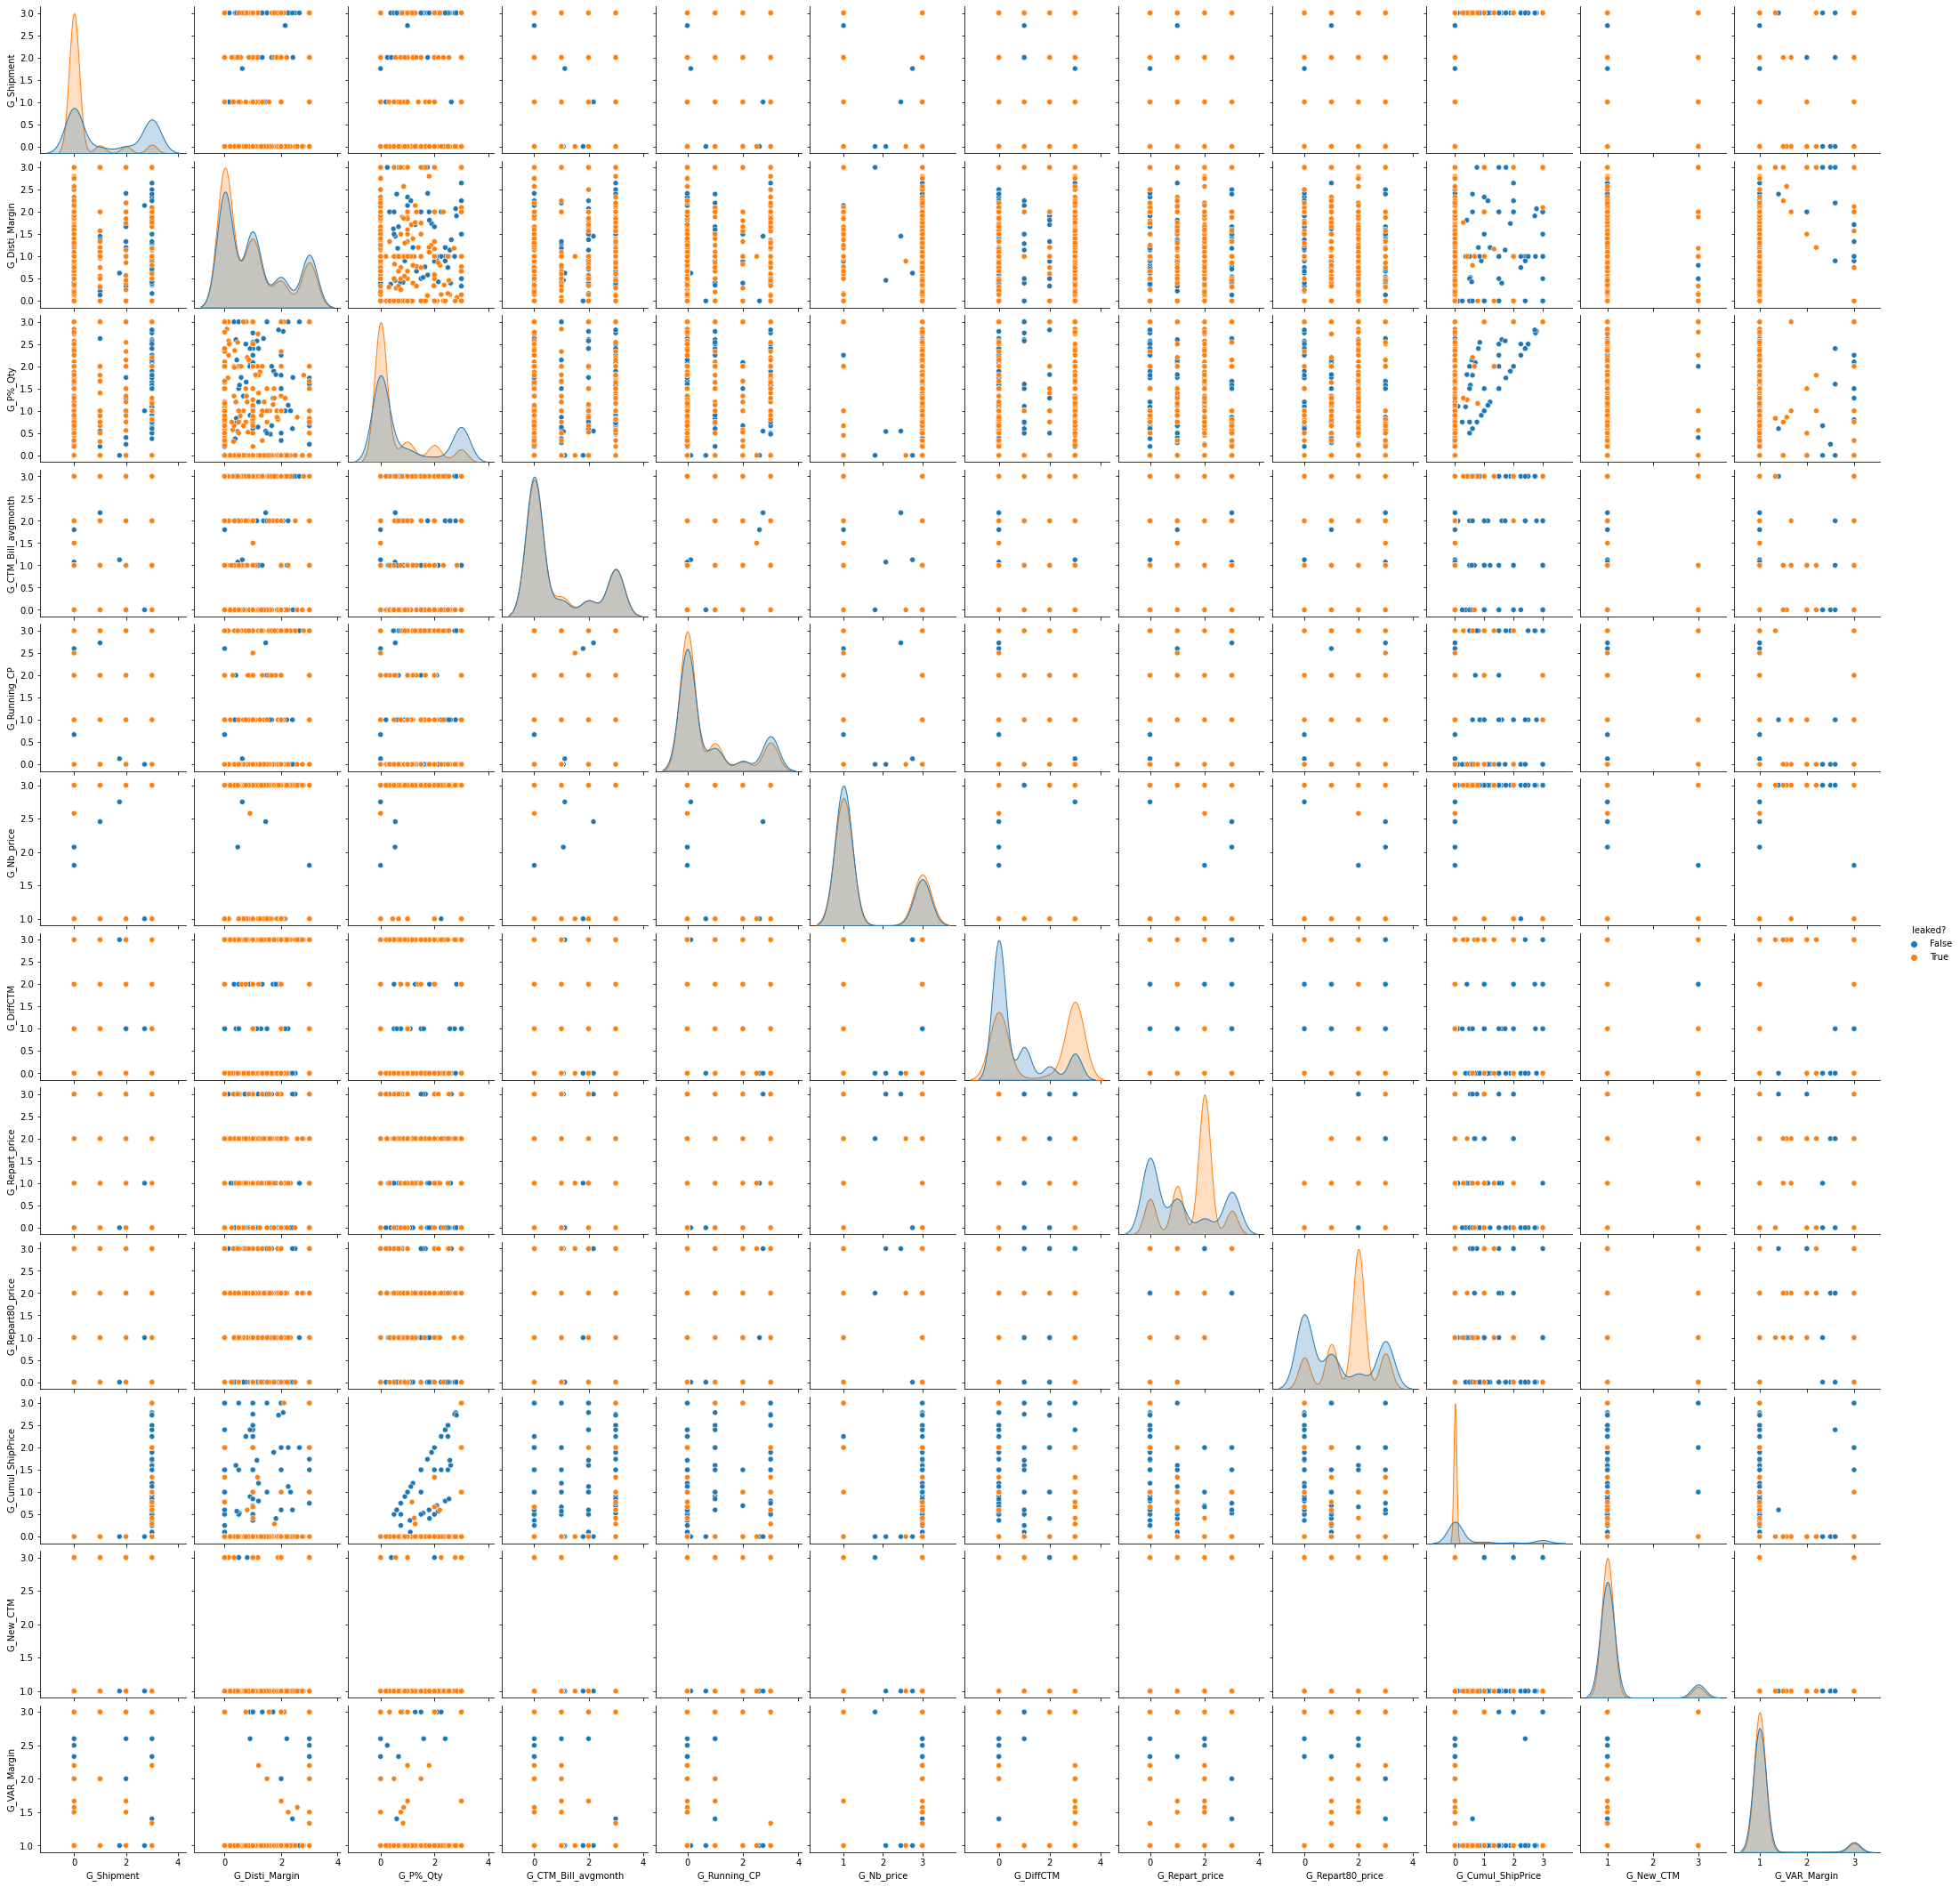

In [31]:
sns.pairplot(data=df_matrix_2021_sample, hue=leaked_column_name)

In [32]:
def test_grade(grade, df):
    grades = set(df[grade])
    ratio_dict = {}

    for value in grades:
        df_tmp = df[df[grade]==value]
        if len(df_tmp)>1:
            ratio_dict[value] = construct_df_ratio(df_tmp)["ratio alarming"].mean()
    return ratio_dict

test_dict = test_grade("G_DiffCTM", df_results_2021)
print(test_dict)

{0: 0.4838753710383321, 1: 0.4239920573402199, 2: 0.2763938113343853, 3: 0.1606280678710842}


In [33]:
df_results_2021.columns

Index(['Year', 'Quarter', 'Channel Sales Area', 'Channel Customer Group',
       'ST Disti Customer Group  - Others', 'ST Disti Ship-To-Name',
       'ST Disti Final Customer Group  - Others', 'Product Division',
       'Commercial Product Code', 'ST Disti Final Ship-To-Name', 'VAR Name',
       'Average_POP', 'Average_POS', 'lowest_pop1', '50%_POP',
       'Sum_Resale_Qty', 'Shipment', 'Disti_Margin', 'Disti_avg_margin',
       'Running_CP', 'CTM_Bill_avgmonth', 'Nb_price', 'DiffCTM',
       'Repart_price', 'Repart80_price', 'G_Shipment', 'G_Disti_Margin',
       'G_P%_Qty', 'G_CTM_Bill_avgmonth', 'G_Running_CP', 'G_Nb_price',
       'G_DiffCTM', 'G_Repart_price', 'G_Repart80_price', 'G_Cumul_ShipPrice',
       'G_New_CTM', 'G_VAR_Margin', 'Average_High', 'Average_Mid',
       'Weight_avg', 'alert_level', 'VAR_Margin', 'nb_alert', 'nb_alarming',
       'P%_Alarming', 'leaked?'],
      dtype='object')

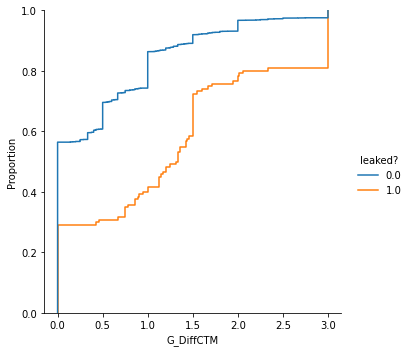

In [34]:
sns.displot(data=df_results_2021.groupby([product_columns_name, "Channel Customer Group"]).mean(), x="G_DiffCTM", hue="leaked?", kind="ecdf")

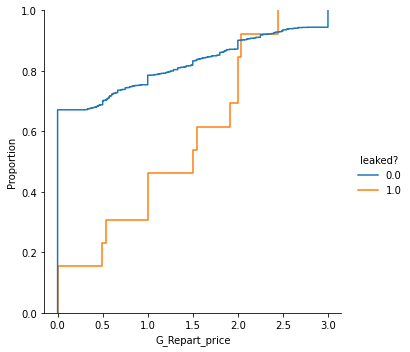

In [35]:
sns.displot(data=df_results_2021.groupby([product_columns_name]).mean(), x="G_Repart_price", hue="leaked?", kind="ecdf")

In [36]:
df_results_2021_F1 = df_results_2021[df_results_2021[product_columns_name].apply(lambda cp:"F1" in cp)]

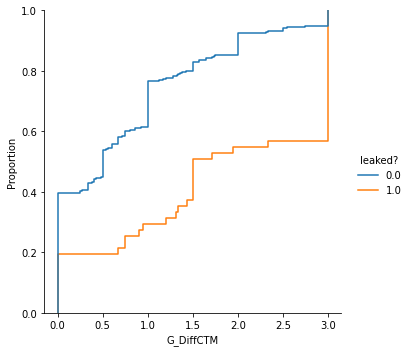

In [37]:
sns.displot(data=df_results_2021_F1.groupby([product_columns_name, "Channel Customer Group"]).mean(), x="G_DiffCTM", hue="leaked?", kind="ecdf")

# Prediction test

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

In [39]:
X_columns = df_matrix_2021_sample.drop(columns=leaked_column_name).columns
X=df_matrix_2021_sample[X_columns]
y=df_matrix_2021_sample[leaked_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [40]:
def run_model(clf):
    model_name = type(clf).__name__
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    print(model_name)
    print(f"Train accuracy= {accuracy_score(y_train, y_pred_train)}")
    print(f"Test accuracy= {accuracy_score(y_test, y_pred_test)}")
    print(confusion_matrix(y_test, y_pred_test))
    print("\n")
    return clf

In [41]:

results = {}
for clf in classifiers:
    run_model(clf)

KNeighborsClassifier
Train accuracy= 0.8866666666666667
Test accuracy= 0.8025
[[309  94]
 [ 64 333]]


SVC
Train accuracy= 0.7775
Test accuracy= 0.7475
[[262 141]
 [ 61 336]]


SVC
Train accuracy= 0.9591666666666666
Test accuracy= 0.75875
[[364  39]
 [154 243]]


GaussianProcessClassifier
Train accuracy= 0.9133333333333333
Test accuracy= 0.8275
[[314  89]
 [ 49 348]]


DecisionTreeClassifier
Train accuracy= 0.8633333333333333
Test accuracy= 0.83125
[[337  66]
 [ 69 328]]


RandomForestClassifier
Train accuracy= 0.8458333333333333
Test accuracy= 0.79
[[293 110]
 [ 58 339]]


MLPClassifier
Train accuracy= 0.8658333333333333
Test accuracy= 0.825
[[324  79]
 [ 61 336]]


AdaBoostClassifier
Train accuracy= 0.8416666666666667
Test accuracy= 0.79625
[[313  90]
 [ 73 324]]


GaussianNB
Train accuracy= 0.705
Test accuracy= 0.685
[[195 208]
 [ 44 353]]


QuadraticDiscriminantAnalysis
Train accuracy= 0.7575
Test accuracy= 0.76125
[[256 147]
 [ 44 353]]


LogisticRegression
Train accuracy= 0.75416

In [42]:
clf_lc = run_model(LogisticRegression())

LogisticRegression
Train accuracy= 0.7541666666666667
Test accuracy= 0.7125
[[271 132]
 [ 98 299]]




In [43]:
df_coef = []
for grade, coef in zip(X_columns, clf_lc.coef_[0]):
    print(f"{grade}: {coef}")
    df_coef.append({"Grade":grade,"Coef":coef})
df_coef = pd.DataFrame(df_coef).sort_values(by="Coef", ascending=False, key=abs)

G_Shipment: -0.7929441241149073
G_Disti_Margin: -0.03330936142760704
G_P%_Qty: 0.09341013954081846
G_CTM_Bill_avgmonth: 0.43286626486690494
G_Running_CP: -0.28582089245260045
G_Nb_price: 0.08452197348163962
G_DiffCTM: 0.6215540673436503
G_Repart_price: -0.19141033485796816
G_Repart80_price: 0.584175106420479
G_Cumul_ShipPrice: -0.6368942861493943
G_New_CTM: -0.1709993860281912
G_VAR_Margin: -0.2849801447580441


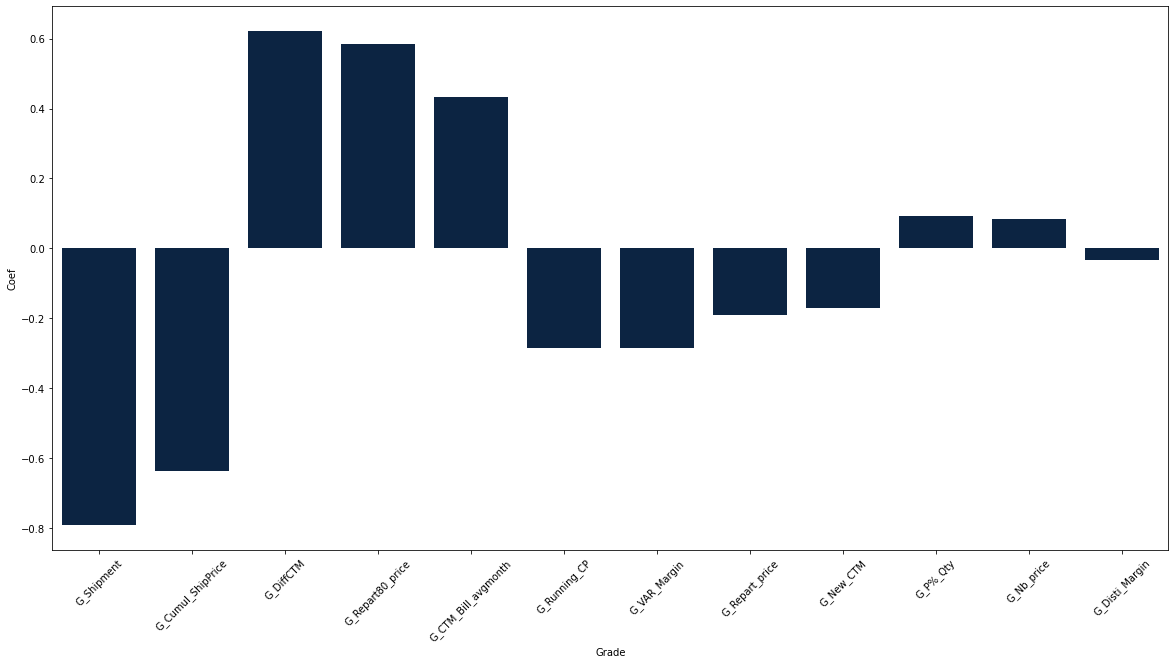

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=45)
g = sns.barplot(ax = ax, data=df_coef, x="Grade", y="Coef", color="#03234B")


DecisionTreeClassifier
Train accuracy= 0.8633333333333333
Test accuracy= 0.83125
[[337  66]
 [ 69 328]]




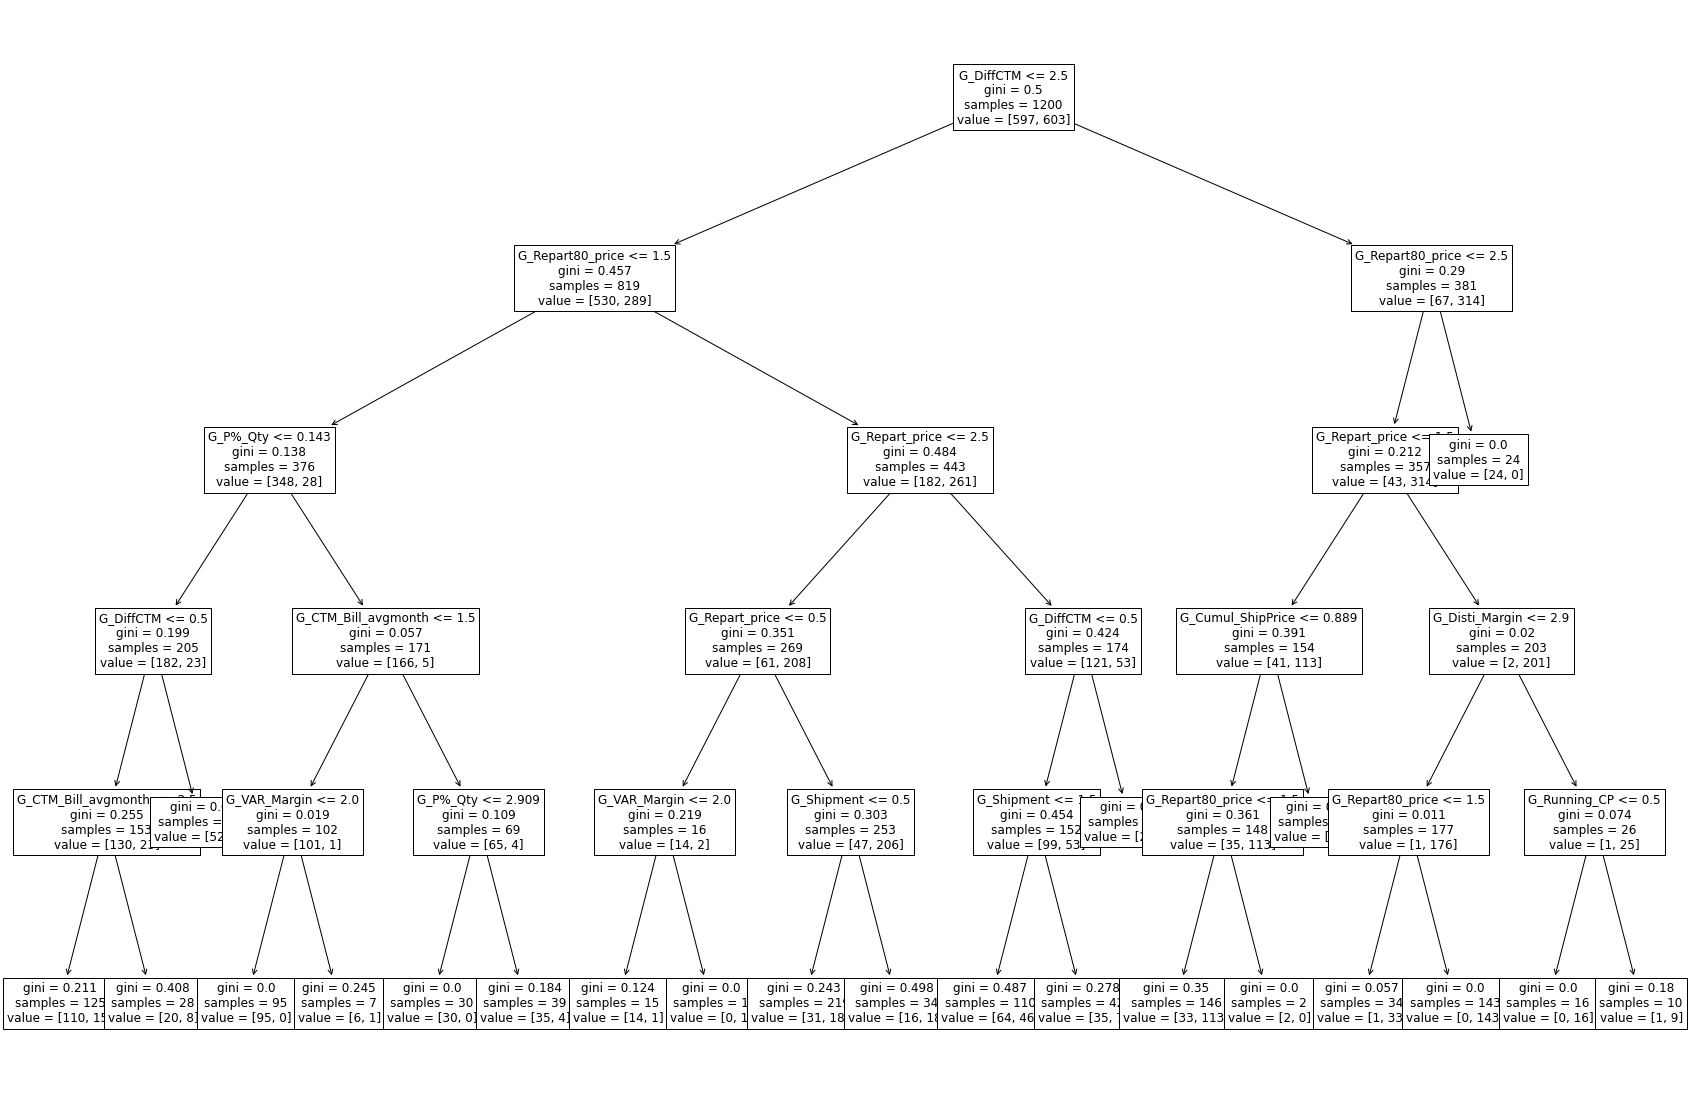

In [45]:
from sklearn.tree import plot_tree
clf_tree = run_model(DecisionTreeClassifier(random_state=0, max_depth=5))
fig = plt.figure(figsize=(30, 20))
plot_tree(clf_tree, feature_names=X_columns, fontsize=12);

In [46]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA()
pca.fit(X)

U = np.transpose(pca.components_) # vecteurs propres
C = pd.DataFrame(X.dot(U), index=X.index) # nouvelles coordonnées
I = pd.DataFrame(np.transpose(pca.explained_variance_ratio_))  # information véhiculée

correlations = pd.DataFrame([[C[facteur].corr(X[column]) for facteur in C] for column in X], index=X.columns)
quality = (C**2).div((X**2).sum(axis=1), axis='index')

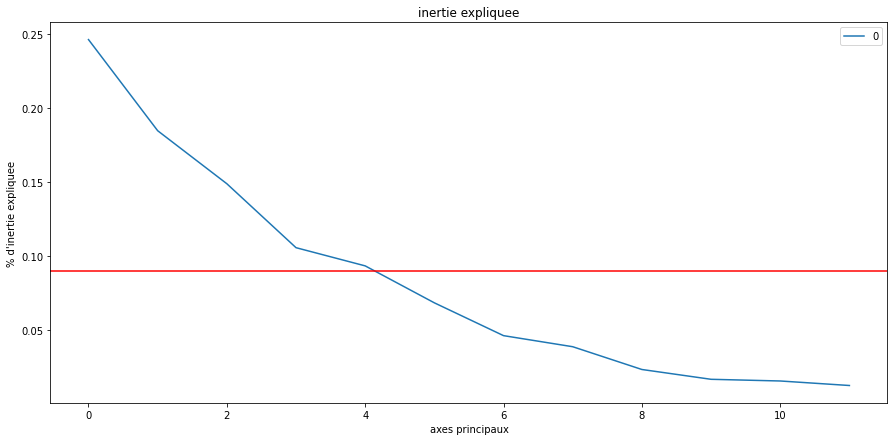

In [48]:
fig, ax = plt.subplots(figsize=(15, 7)) 

I.plot(ax=ax)

plt.title("inertie expliquee")
plt.xlabel("axes principaux")
plt.ylabel("% d'inertie expliquee")

plt.axhline(0.09, color="red")

plt.show() 

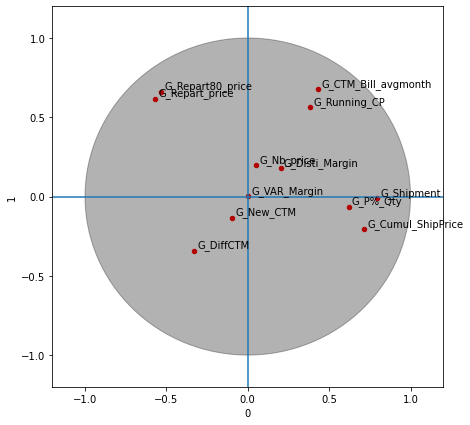

In [49]:
fig, ax = plt.subplots(figsize=(7, 7)) 

draw = correlations[:20].plot.scatter(x=0, y=1, ax=ax, color="red")


for index, row in correlations[:20].iterrows():
    draw.annotate(str(index), (row[0]+0.02, row[1]+0.02))

draw.add_patch(plt.Circle((0, 0), radius=1, color=(0, 0, 0, .3)))

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axvline(0)
plt.axhline(0)

plt.show()

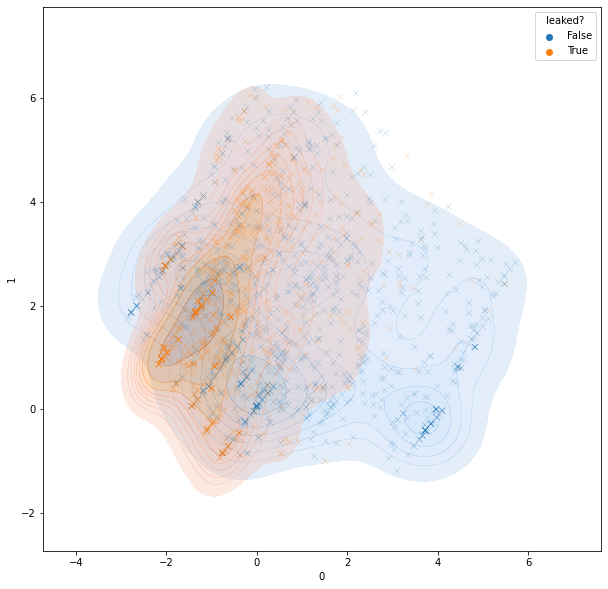

In [50]:
# C["Keyword"]=df_vectors["Keyword"]

fig, ax = plt.subplots(figsize=(10, 10)) 
draw = sns.kdeplot(data=C, x=0, y=1, hue=y, fill=True, alpha=0.3);
draw = sns.scatterplot(data=C, x=0, y=1, hue=y, alpha=0.3, marker="x");

# for index, row in C[:30].iterrows():
#     draw.annotate(row["Keyword"], (row[0]+0.02, row[1]+0.02))

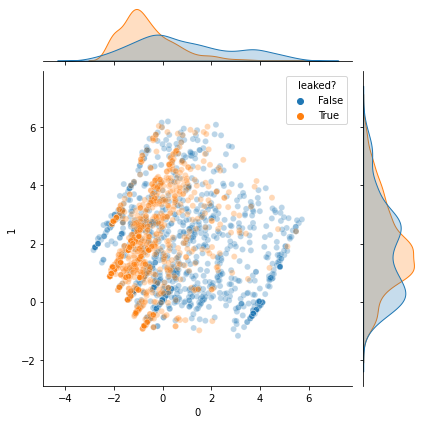

In [51]:
# fig, ax = plt.subplots(figsize=(10, 10));
g = sns.jointplot(data=C, x=0, y=1, hue=y, alpha=0.3);